# AI4PH Data Challenge

Summer 2024

**Yves Nsoga** 
PhD Candidate Biomedical Engineering
University of Calgary
[Data Intelligence for Health Lab](https://cumming.ucalgary.ca/dih)    

In [92]:
# import all packages here 

import pandas as pd
import numpy as np
import cv2

import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import imutils
from skimage import io, transform
import plotly_express as px

In [373]:
# Util functions here 
def stich_image(img_paths: list):
    """stich images with  overlaping to  generate a panoramic view of the POstal  code

    :param img_paths: a list  of image paths
    return panoramic_image
    """
    imgs = []
    for img_path in img_paths:
        img = cv2.imread(img_path)
        imgs.append(img)
    stitchy = cv2.createStitcher() if imutils.is_cv3() else cv2.Stitcher_create()
    (dummy, stiched_output) = stitchy.stitch(imgs)
    if dummy == cv2.STITCHER_OK:
        return stiched_output
    
def crop(stitched: np.array):
    """crop stiched image

    :param image: Image to resize
    :param dimension:  Expected (width, height) of new image, defaults to (800,250)
    :Returns image: Resized image
    """
    stitched = cv2.copyMakeBorder(stitched, 10, 10, 10, 10,
			cv2.BORDER_CONSTANT, (0, 0, 0))
    # convert the stitched image to grayscale and threshold it
    # such that all pixels greater than zero are set to 255
    # (foreground) while all others remain 0 (background)
    gray = cv2.cvtColor(stitched,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]
	# find all external contours in the threshold image then find
	# the *largest* contour which will be the contour/outline of
	# the stitched image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
	# allocate memory for the mask which will contain the
	# rectangular bounding box of the stitched image region
    mask = np.zeros(thresh.shape, dtype="uint8")
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)
    minRect = mask.copy()
    sub = mask.copy()
	# keep looping until there are no non-zero pixels left in the
	# subtracted image
    while cv2.countNonZero(sub) > 0:
		# erode the minimum rectangular mask and then subtract
		# the thresholded image from the minimum rectangular mask
		# so we can count if there are any non-zero pixels left
        minRect = cv2.erode(minRect, None)
        sub = cv2.subtract(minRect, thresh)
    cnts = cv2.findContours(minRect.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    (x, y, w, h) = cv2.boundingRect(c)
	# use the bounding box coordinates to extract the our final
	# stitched image
    stitched = stitched[y:y + h, x:x + w]
    return stitched

def resize(image:np.array,dimension=tuple):
    resized_image = cv2.resize(
    image, dimension, interpolation=cv2.INTER_LINEAR)
    return resized_image


def generate_panorama(root_folder):
    """
    """
    postal_codes = os.listdir(root_folder)
    for index, postal_code in enumerate(postal_codes):
        print(f"**** starting processing postal  code {postal_code} images")
        image_list=[]
        image_path = os.path.join(root_folder,
                                postal_codes[index])

        try:
            for images in os.listdir(image_path):
                # Selecting only horizontal images
                if (images.endswith(".png") and images.startswith(postal_code+'_0')):
                    image_list.append(os.path.join(image_path,
                                                images))
            panorama_view = stich_image(image_list)
            panorama_view_cropped = crop(panorama_view)
            cv2.imwrite(os.path.join(image_path,
                        "pano_view.png"), panorama_view_cropped)
            print(f"*** processing postal code {postal_code} images done ")
        except Exception as e:
            print(f"stiching of Images of postal code:{postal_code} failed, causes:{e}")
                

class zone_panorama_dataset(Dataset):
    """
    """
    def __init__(self,csv_file,root_dir,transform=None):
        """_summary_

        :param csv_file: _description_
        :type csv_file: _type_
        :param root_dir: _description_
        :type root_dir: _type_
        :param transform: _description_, defaults to None
        :type transform: _type_, optional
        """
        self.depravation_indices_data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform =transform
        self.samples = []
        postal_codes = os.listdir(self.root_dir)

        for  postal_code in postal_codes:
            image_path = os.path.join(self.root_dir,
                                      postal_code)
            
            try:
                if os.path.exists(os.path.join(image_path,"pano_view.png")):
                    image = io.imread(os.path.join(image_path,"pano_view.png"))
                    sample = {"image": image,
                            "POSTAL": postal_code,
                            "SCOREMAT": self.depravation_indices_data["SCOREMAT"].loc[self.depravation_indices_data["POSTALCODE_15"] == postal_code].values[0],
                            "SCORESOC": self.depravation_indices_data["SCORESOC"].loc[self.depravation_indices_data["POSTALCODE_15"] == postal_code].values[0]}
                    if self.transform:
                        sample = self.transform(sample)
                    self.samples.append(sample)
            except:
                pass
        

    def __len__(self):
        return len(self.samples)
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index =index.tolist()
        return self.samples[index]


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image= sample['image']
        score_mat = np.asarray([sample["SCOREMAT"]], dtype=np.float32)
        score_soc = np.asarray([sample["SCORESOC"]], dtype=np.float32)

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        transposed_img = image.transpose((2, 0, 1))
        sample['image'] = torch.from_numpy(transposed_img)
        sample["SCOREMAT"] = torch.from_numpy(score_mat)
        sample["SCORESOC"] = torch.from_numpy(score_soc)
        return sample


class Resize(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']
        rescaled_image = transform.resize(image, (150, 450))
        trans= transforms.Compose([
        ])
        sample['image'] = trans(rescaled_image)
        return sample
    

class Net(nn.Module):
    """Convolution  neural network 

    :param nn: _description_
    :type nn: _type_
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(84375, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x)  # flatten all dimensions except batch
        x = F.relu(x)
        x = self.fc1(x)
        return x
net = Net()


# Use pretrained model
model = models.resnet101(weights=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

/Users/yvesnsoganguimbous/miniconda3/envs/data622/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.



In [374]:
generate_panorama("../GSV_Images_AB")

**** starting processing postal  code T2B0E2 images
*** processing postal code T2B0E2 images done 
**** starting processing postal  code T2H2Y6 images
*** processing postal code T2H2Y6 images done 
**** starting processing postal  code T2M2A7 images
*** processing postal code T2M2A7 images done 
**** starting processing postal  code T2C0R1 images
*** processing postal code T2C0R1 images done 
**** starting processing postal  code T2E0H7 images
*** processing postal code T2E0H7 images done 
**** starting processing postal  code T2E5W4 images
*** processing postal code T2E5W4 images done 
**** starting processing postal  code T1Y6H5 images
*** processing postal code T1Y6H5 images done 
**** starting processing postal  code T1Y6G1 images
*** processing postal code T1Y6G1 images done 
**** starting processing postal  code T2E7T1 images
*** processing postal code T2E7T1 images done 
**** starting processing postal  code T2J6J1 images
*** processing postal code T2J6J1 images done 
**** start

In [375]:
depravation_dataset= zone_panorama_dataset(
    csv_file="../Data challenge dataset_complete_no_duplication.csv", root_dir="../GSV_Images_AB", transform=transforms.Compose([Resize()]))
depravation_dataset_transformed = zone_panorama_dataset(
    csv_file="../Data challenge dataset_complete_no_duplication.csv", root_dir="../GSV_Images_AB", transform=transforms.Compose([Resize(),ToTensor()]))

In [376]:
len(depravation_dataset_transformed)

396

<Figure size 640x480 with 0 Axes>

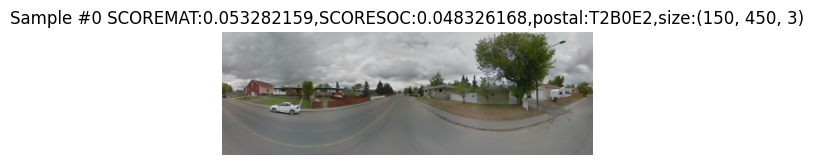

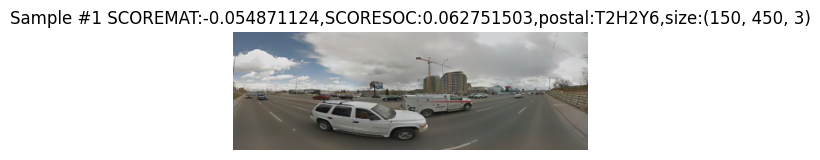

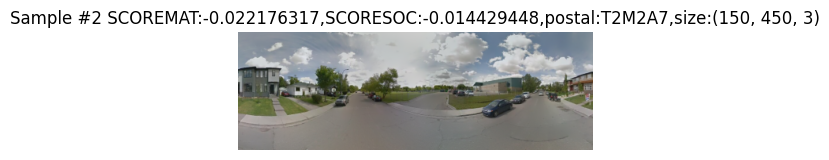

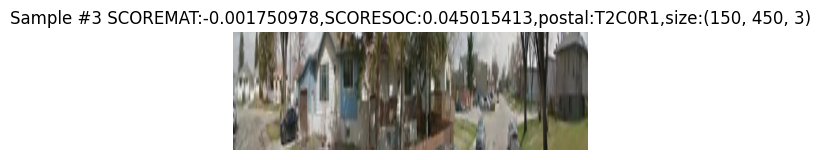

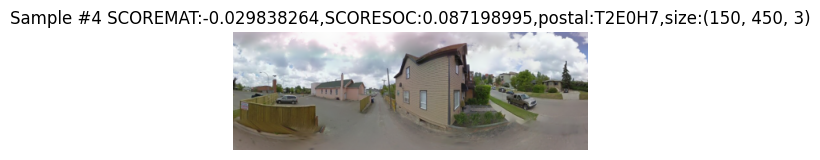

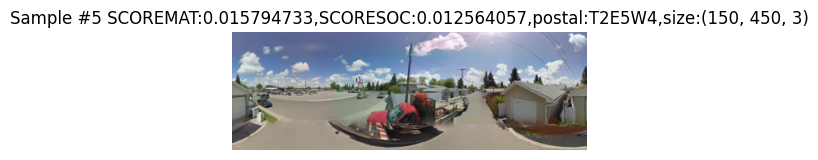

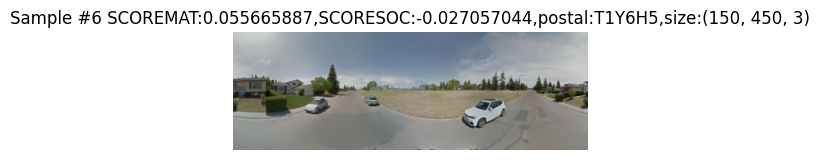

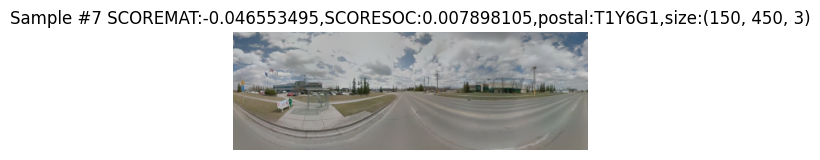

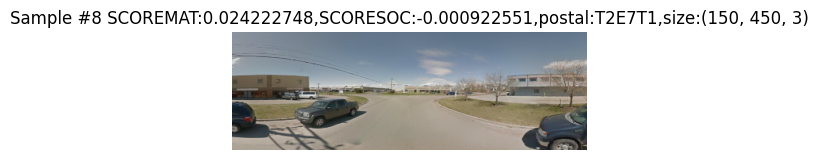

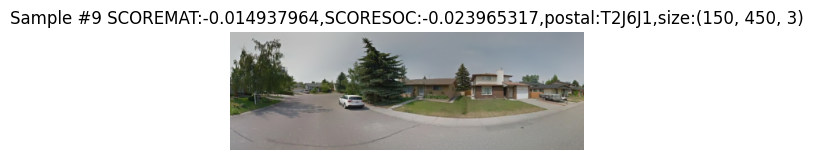

In [377]:
fig = plt.figure()

for i, sample in enumerate(depravation_dataset):
    if sample:
        plt.figure(figsize=[40, 40])
        ax = plt.subplot(1, 10, i + 1)
        plt.tight_layout()
        ax.set_title(f'Sample #{i} SCOREMAT:{sample["SCOREMAT"]},SCORESOC:{sample["SCORESOC"]},postal:{sample["POSTAL"]},size:{sample["image"].shape}')
        ax.axis('off')
        ax.imshow(sample['image'])

    if i == 9:
        plt.show()
        break

In [383]:
#split the dataset into  train and test set and generate train and validation loaders
train_set, val_set = torch.utils.data.random_split(
    depravation_dataset_transformed, [0.7, 0.3])
train_loader = DataLoader(train_set, batch_size=10,
                          shuffle=True, num_workers=0)
test_loader = DataLoader(val_set, batch_size=1,
                         shuffle=True, num_workers=0)

In [384]:
#Fine tune the model
model.float()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
for epoch in range(10):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        mat_score = data["SCOREMAT"]
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data["image"].float())
        loss = criterion(outputs, mat_score)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()*data["SCOREMAT"].size(0)
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss/len(train_loader):.3f}')
print('Finished Training')

[1,    28] loss: 0.524
[2,    28] loss: 0.169
[3,    28] loss: 0.069
[4,    28] loss: 0.063
[5,    28] loss: 0.047
[6,    28] loss: 0.041
[7,    28] loss: 0.056
[8,    28] loss: 0.055
[9,    28] loss: 0.054
[10,    28] loss: 0.035
Finished Training


In [385]:
#Evaluate the model
predictions= []
scores = []
print("Evaluating The model")
model.eval()
for i, data in enumerate(test_loader, 0):
    score = data["SCOREMAT"]
    prediction = model(data["image"].float())
    error = criterion(score, prediction)
    scores.append(score.item())
    predictions.append(prediction.item())

Evaluating The model


In [386]:
#Visualize the predictions and actual  scores
plot_data = pd.DataFrame({"predictions":predictions,"actual":scores})
fig = px.line(plot_data,y=[
               "predictions", "actual"])

fig.show()
